refering to https://github.com/MIC-DKFZ/batchgenerators/blob/master/batchgenerators/examples/example_ipynb.ipynb

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
import warnings
warnings.filterwarnings("ignore")       # ignore warnnings

# DataLoader

In [2]:
from batchgenerators.dataloading.data_loader import DataLoaderBase

class DataLoader(DataLoaderBase):
    def __init__(self, data, BATCH_SIZE=2, num_batches=None, seed=False):
        super(DataLoader, self).__init__(data, BATCH_SIZE, num_batches, seed) 
        # data is now stored in self._data.
    
    def generate_train_batch(self):
        # usually you would now select random instances of your data. We only have one therefore we skip this
        img = self._data
        
        # The camera image has only one channel. Our batch layout must be (b, c, x, y). Let's fix that
        img = np.tile(img[None, None], (self.BATCH_SIZE, 1, 1, 1))
        
        # now construct the dictionary and return it. np.float32 cast because most networks take float
        return {'data':img.astype(np.float32), 'some_other_key':'some other value'}

Now we can view some batches:

/home/hlq/anaconda3/lib/python3.9/site-packages/batchgenerators/dataloading/data_loader.py:53: DeprecationWarning: This DataLoader will soon be removed. Migrate everything to SlimDataLoaderBase now!
  warn("This DataLoader will soon be removed. Migrate everything to SlimDataLoaderBase now!", DeprecationWarning)


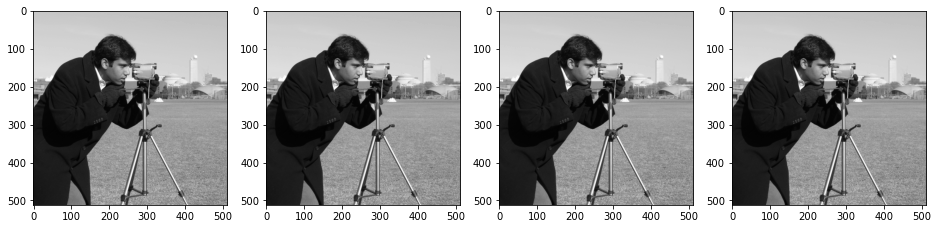

In [3]:
batchgen = DataLoader(data.camera(), 4, None, False)
batch = next(batchgen)

def plot_batch(batch):
    batch_size = batch['data'].shape[0]
    plt.figure(figsize=(16, 10))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(batch['data'][i, 0], cmap="gray") # only grayscale image here
    plt.show()


plot_batch(batch)

# Lets add some deformations, scaling and rotations.

We use very aggressive parameters here to visualize the effects. In your experiment you should choose parameters that make sense in the context of your data. Not how we are using angle_z here. We are rotating around the (nonexistent) z axis. Always double check whether the rotations are around the correct axis.

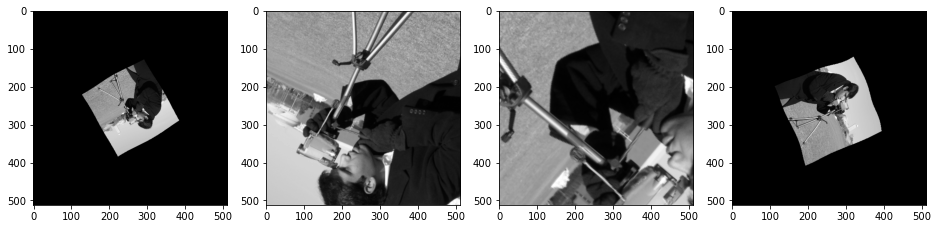

In [4]:
from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
from batchgenerators.transforms.spatial_transforms import SpatialTransform

my_transforms = []

spatial_transform = SpatialTransform(data.camera().shape, np.array(data.camera().shape) // 2, 
                 do_elastic_deform=True, alpha=(0., 1500.), sigma=(30., 50.),
                 do_rotation=True, angle_z=(0, 2 * np.pi),                                      # do deform && rotate && scale && W/O crop
                 do_scale=True, scale=(0.3, 3.),        # range
                 border_mode_data='constant', border_cval_data=0, order_data=1,
                 random_crop=False)

my_transforms.append(spatial_transform)
all_transforms = Compose(my_transforms)
multithreaded_generator = MultiThreadedAugmenter(batchgen, all_transforms, 4, 2, seeds=None)

# you can run this line several times to see different outputs. Note how the computation takes long for the 
# first run, but then the batches are returnes very quickly!
plot_batch(next(multithreaded_generator))